# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp drive/MyDrive/DisLandReviews/contractions.py .

In [3]:
!pip install textblob --quiet

In [4]:
import os
import io
import re
import time
import nltk
import spacy
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
from textblob import TextBlob
from google.colab import files
from matplotlib import pyplot as plt
from nltk.probability import FreqDist
from contractions import CONTRACTION_MAP
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [5]:
!python -m spacy download en --quiet

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Helper Functions
- text-processing

In [7]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

# def lemmatize_text(text):
#     text = nlp(text)
#     # text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
#     text = ' '.join([word.lemma_ for word in text])
#     return text

def remove_stopwords(text, is_lower_case=True):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token.lower() for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Helper functions
- freq_count, BOW, plotting, printing reviews

In [8]:
def word_freq(clean_reviews, FILE_NAME):
    # CSV_PATH must end with 'filename.csv' example '/content/drive/MyDrive/DisLandReviews/pos_freq.csv'
    # PLT_PATH must end with 'filename.png' example '/content/drive/MyDrive/DisLandReviews/pos_freq.png'
    tokenizer = ToktokTokenizer()
    stopword_list = nltk.corpus.stopwords.words('english')
    flat_doc_stops = []
    for review in clean_reviews:
      tokens = tokenizer.tokenize(review)
      for token in tokens:
        if token in stopword_list: 
          tokens.remove(token)
      flat_doc_stops.append(tokens)
    flat_list = [item for sublist in flat_doc_stops for item in sublist]

    fdist = FreqDist(flat_list)
    fdist_df = pd.DataFrame.from_dict(fdist, orient='index').reset_index()
    fdist_df.columns = ['Word','Count']
    ordered = fdist_df.sort_values('Count', ascending=False)
    filtered = ordered[ordered['Count'] > 0]
    filtered.to_csv('/content/drive/MyDrive/DisLandReviews/'+FILE_NAME+'.csv')
    
    plt.figure(figsize=(20,10))
    sns.barplot(data=filtered.head(50), x='Count', y='Word')
    plt.title('Word Count Distribution \n', fontsize=16)
    plt.savefig('/content/drive/MyDrive/DisLandReviews/'+FILE_NAME+'.png', transparent=True)
    plt.show()    

In [9]:
def bow_freq(nostop_reviews, FILE_NAME):
    rev_ = ''
    for review in nostop_reviews:
        rev_+= review+' '
    rev = []
    rev.append(rev_)

    two_word = TfidfVectorizer(ngram_range=(2,2))
    three_word = TfidfVectorizer(ngram_range=(3,3))
    bow2 = two_word.fit_transform(rev).toarray()
    bow3 = three_word.fit_transform(rev).toarray()
    top_50_2 = pd.DataFrame(bow2, columns=two_word.get_feature_names()).T.reset_index().sort_values(by=0, ascending=False).head(50)
    top_50_3 = pd.DataFrame(bow3, columns=three_word.get_feature_names()).T.reset_index().sort_values(by=0, ascending=False).head(50)
    top_50_2.rename(columns={'index':'Terms', 0:'% Freq in Thesis'}, inplace=True)
    top_50_3.rename(columns={'index':'Terms', 0:'% Freq in Thesis'}, inplace=True)
    top_50_2.to_csv('/content/drive/MyDrive/DisLandReviews/'+FILE_NAME+'_2_50.csv')
    top_50_3.to_csv('/content/drive/MyDrive/DisLandReviews/'+FILE_NAME+'_3_50.csv')
    return top_50_2 , top_50_3

In [10]:
# def word_freq_graph(sorted_data):
#     plt.figure(figsize=(20,10))
#     sns.barplot(data=sorted_data.head(50), x='Count', y='Word')
#     plt.title('Word Count Distribution \n', fontsize=16)
#     plt.show()

In [11]:
def bow_freq_graph(sorted_data, FILE_NAME):
    plt.figure(figsize=(20,10))
    sns.barplot(data=sorted_data.head(50), x='% Freq in Thesis', y='Terms')
    plt.title('Word Count Distribution \n', fontsize=16)
    plt.savefig('/content/drive/MyDrive/DisLandReviews/'+FILE_NAME+'.png', transparent=True)
    plt.show()

In [12]:
def best_worst_rev(df, column, delim):
    pos_idx = df[(df[column] == delim) & (df.sentiment_score == df.sentiment_score.max())].index[0]
    neg_idx = df[(df[column] == delim) & (df.sentiment_score == df.sentiment_score.min())].index[0]
    print(f'Most negative review with a score of {df.sentiment_score.min()}:', df.loc[neg_idx][['clean']][0])
    print()
    print(f'Most positive review with a score of {df.sentiment_score.max()}:', df.loc[pos_idx][['clean']][0])

# Reading in data

In [13]:
disrev = pd.read_csv('/content/drive/MyDrive/DisLandReviews/CSVs/DisneylandReviews.csv', encoding='latin-1')
disrev.drop(columns=['Review_ID','Year_Month'], inplace=True)

# Processing Data

In [14]:
nlp = spacy.load('en_core_web_sm')
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

allgood = ['no','not','while','against','through','during','before','after','above','below','up','down','in','out','on','off','over','under','again','any','nor']
addin = ['I','pm','PM','AM', 'The']

for word in allgood:
  stopword_list.remove(word)

for word in addin:
  stopword_list.append(word)

In [15]:
start = time.time()

special_char_pattern = re.compile(r'([{.(-)!}])')
disrev['clean'] = [re.sub(' +', ' ', rev) for rev in disrev.Review_Text]
disrev['clean'] = [re.sub(' t ', '\'t ', rev) for rev in disrev.clean]
disrev['clean'] = [remove_accented_chars(rev) for rev in disrev.clean]
disrev['clean'] = [expand_contractions(rev) for rev in disrev.clean]
disrev['clean'] = [special_char_pattern.sub(" \\1 ", rev) for rev in disrev.clean]
disrev['clean'] = [remove_special_characters(rev) for rev in disrev.clean]
disrev['no_stops'] = [remove_stopwords(rev) for rev in disrev.clean]
disrev['rev_len'] = [len(rev) for rev in disrev.clean]
# disrev['lemma_text'] = [lemmatize_text(rev) for rev in disrev.clean]
# disrev.to_csv('/content/drive/MyDrive/DisLandReviews/clean_reviews.csv')
# disrev.to_csv('C:/Users/Juss/Documents/GitHub/DisLandReviews/clean_reviews.csv')

print(f'runtime:{time.time()-start} seconds')

runtime:78.78321623802185 seconds


# Sentiment Analysis

In [16]:
# disrev = pd.read_csv('/content/drive/MyDrive/DisLandReviews/clean_reviews.csv', index_col=None)
# disrev.drop(columns='Unnamed: 0', inplace=True)

## Local Import

# disrev = pd.read_csv('C:/Users/Juss/Documents/GitHub/DisLandReviews/clean_reviews.csv', index_col=None)
# disrev.drop(columns='Unnamed: 0', inplace=True)

In [47]:
sentiment_scores_tb = [round(TextBlob(review).sentiment.polarity, 3) for review in disrev['no_stops']]
# sentiment_category_tb = ['positive' if score > 0.333 else 'negative' if score < -0.333 else 'neutral' for score in sentiment_scores_tb]
# sentiment_category_tb = ['positive' if score > 0.167 else 'negative' if score < -0.167 else 'neutral' for score in sentiment_scores_tb]
sentiment_category_tb = ['positive' if score > 0.05 else 'negative' if score < -0.05 else 'neutral' for score in sentiment_scores_tb]
# sentiment_category_tb = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in sentiment_scores_tb]

In [88]:
sentiment_df = pd.DataFrame([list(disrev.Branch), list(disrev.Reviewer_Location), list(disrev['Rating']), sentiment_scores_tb, sentiment_category_tb, list(disrev.Review_Text), list(disrev.clean), list(disrev.no_stops), list(disrev.rev_len)]).T
sentiment_df.columns = ['branch', 'country', 'rating',  'sentiment_score', 'sentiment_category', 'review_text', 'clean', 'no_stops', 'rev_len']
sentiment_df['sentiment_score'] = sentiment_df.sentiment_score.astype('float')
sentiment_df['rating'] = sentiment_df.rating.astype('int64')
# sentiment_df.to_csv('/content/drive/MyDrive/DisLandReviews/no_stops_sentiments.csv')
# sentiment_df.to_csv('C:/Users/Juss/Documents/GitHub/DisLandReviews/sentiments.csv')
# sentiment_df.head(10)

# Different Segments 

WordCounts, B.O.W., and Most Neg&Pos reviews by sentiment_score

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/DisLandReviews/CSVs/sentiments.csv', encoding='latin-1')
sentiment_df.drop(columns='Unnamed: 0', inplace=True)
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   branch              42656 non-null  object 
 1   country             42656 non-null  object 
 2   rating              42656 non-null  int64  
 3   sentiment_score     42656 non-null  float64
 4   sentiment_category  42656 non-null  object 
 5   review_text         42656 non-null  object 
 6   clean               42656 non-null  object 
 7   no_stops            42656 non-null  object 
 8   rev_len             42656 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 2.9+ MB


## Segmenting Branches

In [ ]:
pd.crosstab(sentiment_df.branch, sentiment_df.rating)

rating,1,2,3,4,5
branch,,,,,
Disneyland_California,499,747,1661,3981,12518
Disneyland_HongKong,172,336,1365,3230,4517
Disneyland_Paris,828,1044,2083,3564,6111


In [ ]:
sentiment_df.groupby(by=['branch']).describe()

In [ ]:
plt.figure(figsize=(25,15))
sns.catplot(x="branch", hue="sentiment_category", 
                    data=sentiment_df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})
plt.title('Sentiment by branch \n', fontsize=16)

# plt.savefig('/content/drive/MyDrive/DisLandReviews/sentiment_branch.png', transparent=True)
# plt.savefig('C:/Users/Juss/Documents/GitHub/DisLandReviews/sentiment_branch.png', transparent=True)
plt.show()

In [113]:
ca = sentiment_df[sentiment_df['branch'] == 'Disneyland_California']
pa = sentiment_df[sentiment_df['branch'] == 'Disneyland_Paris']
hk = sentiment_df[sentiment_df['branch'] == 'Disneyland_HongKong']

### California

In [ ]:
ca_pos = ca[ca['sentiment_category'] == 'positive']
ca_neu = ca[ca['sentiment_category'] == 'neutral']
ca_neg = ca[ca['sentiment_category'] == 'negative']

#### CA positive

In [ ]:
best_worst_rev(ca_pos, 'branch', 'Disneyland_California')

Most negative review with a score of 0.051: With two of my girlfriends we visited Disneyland   It was a bucket list item and for the most part fun   Finding our way to attractions we wanted to see was more difficult then it should of been but we managed to get there when the park opened and enjoy three fast pass attractions   The food and water was a little expensive   Since we visited during Spring break time the regular price was increased by    There were  attractions closed which included the Cinderella Castle   For the extra money all things should be open   Lots of strollers scooters and people everywhere by pm   

Most positive review with a score of 1.0: It s always a blast to go to Disneyland   Going over President s Day Weekend was awesome because the park was not too crowded  


In [ ]:
word_freq(ca_pos.no_stops, 'ca_pos')

In [ ]:
top_2, top_3 = bow_freq(ca_pos.no_stops, 'ca_pos')

In [ ]:
bow_freq_graph(top_2, 'ca_pos_2_50')

In [ ]:
bow_freq_graph(top_3, 'ca_pos_3_50')

#### CA neutral

In [ ]:
best_worst_rev(ca_neu, 'branch', 'Disneyland_California')

In [ ]:
word_freq(ca_neu.no_stops, 'ca_neu')

In [ ]:
top_2, top_3 = bow_freq(ca_neu.no_stops, 'ca_neu')

In [ ]:
bow_freq_graph(top_2, 'ca_neu_2_50')

In [ ]:
bow_freq_graph(top_3, 'ca_neu_3_50')

#### CA negative

In [ ]:
best_worst_rev(ca_neg, 'branch', 'Disneyland_California')

Most negative review with a score of -1.0: Been to one been to all       Gets a bit boring after a while but I suppose you have to do what the kids say you got to do        

Most positive review with a score of -0.051: Made my th trip to Disneyland and our first in February   Why then Because that was supposed to THE month to beat all the crazy crowd madness the month things quieted down there   with the notable exception of the week of Presidents Day     It was sheer folly   Disney parks have become a fanatical religion with families over the years and there is never ever a remotely quiet day   The crowds were absolute craziness at all times   There were areas of Tomorrowland and New Orleans Square that it was literally impossible to walk through due to the suffocating crush of bodies   and I have walked the streets of New Delhi which seems like a peaceful quaint village in comparison     Do not get me wrong the Disney experience is still great there is nothing else like it but do no

In [ ]:
word_freq(ca_neg.no_stops, 'ca_neg')

In [ ]:
top_2, top_3 = bow_freq(ca_neg.no_stops, 'ca_neg')

In [ ]:
bow_freq_graph(top_2, 'ca_neg_2_50')

In [ ]:
bow_freq_graph(top_3, 'ca_neg_3_50')

### Paris

In [ ]:
pa_pos = pa[pa['sentiment_category'] == 'positive'] 
pa_neu = pa[pa['sentiment_category'] == 'neutral'] 
pa_neg = pa[pa['sentiment_category'] == 'negative'] 

#### PA positive

In [ ]:
best_worst_rev(pa_pos, 'branch', 'Disneyland_Paris')

In [ ]:
word_freq(pa_pos.no_stops, 'pa_pos')

In [ ]:
top_2, top_3 = bow_freq(pa_pos.no_stops, 'pa_pos')

In [ ]:
bow_freq_graph(top_2, 'pa_pos_2_50')

In [ ]:
bow_freq_graph(top_3, 'pa_pos_3_50')

#### PA neutral

In [ ]:
best_worst_rev(pa_neu, 'branch', 'Disneyland_Paris')

In [ ]:
word_freq(pa_neu.no_stops, 'pa_neu')

In [ ]:
top_2, top_3 = bow_freq(pa_neu.no_stops, 'pa_neu')

In [ ]:
bow_freq_graph(top_2, 'pa_neu_2_50')

In [ ]:
bow_freq_graph(top_3, 'pa_neu_3_50')

#### PA negative

In [ ]:
best_worst_rev(pa_neg, 'branch', 'Disneyland_Paris')

In [ ]:
word_freq(pa_neg.no_stops, 'pa_neg')

In [ ]:
top_2, top_3 = bow_freq(pa_neg.no_stops, 'pa_neg')

In [ ]:
bow_freq_graph(top_2, 'pa_neg_2_50')

In [ ]:
bow_freq_graph(top_3, 'pa_neg_3_50')

### Hong Kong

In [ ]:
hk_pos = hk[hk['sentiment_category'] == 'positive'] 
hk_neu = hk[hk['sentiment_category'] == 'neutral'] 
hk_neg = hk[hk['sentiment_category'] == 'negative'] 

#### HK positive

In [ ]:
best_worst_rev(hk_pos, 'branch', 'Disneyland_HongKong')

In [ ]:
word_freq(hk_pos.no_stops, 'hk_pos')

In [ ]:
top_2, top_3 = bow_freq(hk_pos.no_stops, 'hk_pos')

In [ ]:
bow_freq_graph(top_2, 'hk_pos_2_50')

In [ ]:
bow_freq_graph(top_3, 'hk_pos_3_50')

#### HK neutral

In [ ]:
best_worst_rev(hk_neu, 'branch', 'Disneyland_HongKong')

In [ ]:
word_freq(hk_neu.no_stops, 'hk_neu')

In [ ]:
top_2, top_3 = bow_freq(hk_neu.no_stops, 'hk_neu')

In [ ]:
bow_freq_graph(top_2, 'hk_neu_2_50')

In [ ]:
bow_freq_graph(top_3, 'hk_neu_3_50')

#### HK negative

In [ ]:
best_worst_rev(hk_neg, 'branch', 'Disneyland_HongKong')

In [ ]:
word_freq(hk_neg.no_stops, 'hk_neg')

In [ ]:
top_2, top_3 = bow_freq(hk_neg.no_stops, 'hk_neg')

In [ ]:
bow_freq_graph(top_2, 'hk_neg_2_50')

In [ ]:
bow_freq_graph(top_3, 'hk_neg_3_50')

## Segmenting by Rating

In [ ]:
sentiment_df.groupby(by=['rating']).describe()

<Figure size 1800x1080 with 0 Axes>

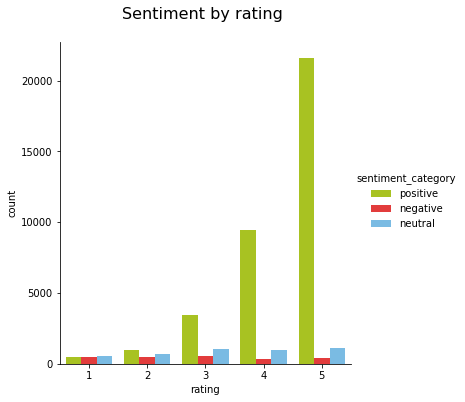

In [ ]:
plt.figure(figsize=(25,15))
sns.catplot(x="rating", hue="sentiment_category", 
                    data=sentiment_df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})
plt.title('Sentiment by rating \n', fontsize=16)
# plt.savefig('/content/drive/MyDrive/DisLandReviews/sentiment_rating.png', transparent=True)
# plt.savefig('C:/Users/Juss/Documents/GitHub/DisLandReviews/sentiment_rating.png', transparent=True)
plt.show()

In [132]:
one_star = sentiment_df[sentiment_df['rating'] == 1]
two_star = sentiment_df[sentiment_df['rating'] == 2]
thr_star = sentiment_df[sentiment_df['rating'] == 3]
fou_star = sentiment_df[sentiment_df['rating'] == 4]
fiv_star = sentiment_df[sentiment_df['rating'] == 5]

### one-star

In [ ]:
word_freq(one_star.no_stops, 'one_star')

In [ ]:
top_2, top_3 = bow_freq(one_star.no_stops, 'one_star')

In [ ]:
bow_freq_graph(top_2, 'one_star_2_50')

In [ ]:
bow_freq_graph(top_3, 'one_star_3_50')

In [ ]:
best_worst_rev(one_star, 'rating', 1)

### two-star

In [ ]:
word_freq(two_star.no_stops, 'two_star')

In [ ]:
top_2, top_3 = bow_freq(two_star.no_stops, 'two_star')

In [ ]:
bow_freq_graph(top_2, 'two_star_2_50')

In [ ]:
bow_freq_graph(top_3, 'two_star_3_50')

In [ ]:
best_worst_rev(two_star, 'rating', 2)

### three-star

In [ ]:
word_freq(thr_star.no_stops, 'thr_star')

In [ ]:
top_2, top_3 = bow_freq(thr_star.no_stops, 'thr_star')

In [ ]:
bow_freq_graph(top_2, 'thr_star_2_50')

In [ ]:
bow_freq_graph(top_3, 'thr_star_3_50')

In [ ]:
best_worst_rev(thr_star, 'rating', 3)

### four-star

In [ ]:
word_freq(fou_star.no_stops, 'fou_star')

In [ ]:
top_2, top_3 = bow_freq(fou_star.no_stops, 'fou_star')

In [ ]:
bow_freq_graph(top_2, 'fou_star_2_50')

In [ ]:
bow_freq_graph(top_3, 'fou_star_3_50')

In [ ]:
best_worst_rev(fou_star, 'rating', 4)

### five-star

In [ ]:
word_freq(fiv_star.no_stops, 'fiv_star')

In [ ]:
top_2, top_3 = bow_freq(fiv_star.no_stops, 'fiv_star')

In [ ]:
bow_freq_graph(top_2, 'fiv_star_2_50')

In [ ]:
bow_freq_graph(top_3, 'fiv_star_3_50')

In [ ]:
best_worst_rev(fiv_star, 'rating', 5)

## Segmenting by Sentiment

In [ ]:
sentiment_df.groupby(by=['sentiment_category']).describe()

sentiment_score                      ...                     
                             count      mean       std  ...    50%    75%    max
sentiment_category                                      ...                     
negative                    2242.0 -0.148830  0.104993  ... -0.117 -0.080 -0.051
neutral                     4379.0  0.007636  0.028245  ...  0.009  0.033  0.050
positive                   36035.0  0.258117  0.142850  ...  0.233  0.333  1.000

[3 rows x 8 columns]

In [ ]:
pos = sentiment_df[sentiment_df['sentiment_category'] == 'positive']
neu = sentiment_df[sentiment_df['sentiment_category'] == 'neutral']
neg = sentiment_df[sentiment_df['sentiment_category'] == 'negative']

### Positive

In [ ]:
word_freq(pos.no_stops, 'pos')

In [ ]:
top_2, top_3 = bow_freq(pos.no_stops, 'pos')

In [ ]:
bow_freq_graph(top_2, 'pos_2_50')

In [ ]:
bow_freq_graph(top_3, 'pos_3_50')

In [ ]:
best_worst_rev(pos, 'sentiment_category', 'positive')

### Neutral

In [ ]:
word_freq(neu.no_stops, 'neu')

In [ ]:
top_2, top_3 = bow_freq(neu.no_stops, 'neu')

In [ ]:
bow_freq_graph(top_2, 'neu_2_50')

In [ ]:
bow_freq_graph(top_3, 'neu_3_50')

In [ ]:
best_worst_rev(neu, 'sentiment_category', 'neutral')

### Negative

In [ ]:
word_freq(neg.no_stops, 'neg')

In [ ]:
top_2, top_3 = bow_freq(neg.no_stops, 'neg')

In [ ]:
bow_freq_graph(top_2, 'neg_2_50')

In [ ]:
bow_freq_graph(top_3, 'neg_3_50')

In [ ]:
best_worst_rev(neg, 'sentiment_category', 'negative')

# Geo

In [19]:
!pip install geopandas --quiet
import geopandas

     |████████████████████████████████| 1.0MB 4.3MB/s 
     |████████████████████████████████| 6.5MB 21.4MB/s 
     |████████████████████████████████| 14.8MB 304kB/s 


In [89]:
world_gdf = geopandas.read_file('/content/drive/MyDrive/DisLandReviews/gadm36.gpkg', driver='GPKG')

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


## Percent of reviews by country per park

In [101]:
ish = dict(hk.country.value_counts())
# ish

In [ ]:
cntry_percent = []
n = 1
for cntry in hk.country:
  cntry_percent.append(round((ish[cntry]/hk.shape[0]) * 100, 5 ))
  print(n, ' of ', hk.shape[0])
  n += 1

In [ ]:
hk['country_percent'] = cntry_percent
hk.drop(columns=['branch','review_text','clean','no_stops','rev_len','sentiment_category','rating','sentiment_score'], inplace=True)
hk.drop_duplicates(inplace=True)

In [104]:
countries = []
percents = []
for countr in hk.country:
  countries.append(countr)
  for percent in hk.country_percent:
    percents.append(percent)

cntry_per_dict = dict(zip(countries, percents))

In [ ]:
cntries = []
n = 1
for cntry in world_gdf.NAME_0:
  cntries.append(cntry)
  print(n, ' of ', world_gdf.shape[0])
  n += 1


country_list = set(cntries)
print(len(cntries))
print(len(country_list))

In [106]:
locs = []
cents = []

for location in country_list:
  locs.append(location)
  for x in range(len(country_list)):
    x = np.nan
    cents.append(x)

world_dict = dict(zip(locs, cents))

In [107]:
not_in_ = {}
for place, v in world_dict.items():
  if place in cntry_per_dict.keys():
    pass
  else:
    not_in_[place] = np.nan

In [108]:
cntry_per_dict.update(not_in_)

In [109]:
samp = geopandas.GeoDataFrame()
samp['Code'] = world_gdf.GID_0
samp['Country'] = world_gdf.NAME_0
samp['Zone'] = world_gdf.zone
samp['geometry'] = world_gdf.geometry

In [ ]:
df_loc = dict(hk.country.value_counts())
df_loc

In [ ]:
gdf_loc = dict(samp.Country.value_counts())
gdf_loc

In [85]:
def this(db, old, new):
  cntry_per_dict[new] = round(ish[old] / db.shape[0] * 100, 5)
  print(cntry_per_dict[new])

In [ ]:
this(hk, 'Macau', 'Macao')
this(hk, 'Myanmar (Burma)', 'Myanmar')
this(hk, 'The Bahamas', 'Bahamas')
this(hk, 'Falkland Islands (Islas Malvinas)', 'Falkland Islands')
this(hk, 'Czechia', 'Czech Republic')

In [ ]:
this(pa, 'Macau', 'Macao')
this(pa, 'Myanmar (Burma)', 'Myanmar')
# this(pa, 'Macedonia', 'North Macedonia')
this(pa, 'Åland Islands', 'Åland')
this(pa, 'Czechia', 'Czech Republic')

In [ ]:
this(ca, 'Macau', 'Macao')
this(ca, 'U.S. Virgin Islands', 'Virgin Islands, U.S.')
this(ca, 'Caribbean Netherlands', 'Bonaire, Sint Eustatius and Saba')
this(ca, 'Czechia', 'Czech Republic')
this(ca, 'Falkland Islands (Islas Malvinas)', 'Falkland Islands')
this(ca, 'The Bahamas', 'Bahamas')

In [ ]:
percents = []
n = 1
for cntry in world_gdf.NAME_0:
  percents.append(cntry_per_dict[cntry])
  print(n, ' of ', world_gdf.shape[0])
  n += 1

In [116]:
world_gdf['country_percent'] = percents
samp = geopandas.GeoDataFrame()
samp['Code'] = world_gdf.GID_0
samp['Country'] = world_gdf.NAME_0
samp['Zone'] = world_gdf.zone
samp['geometry'] = world_gdf.geometry
samp['country_percent'] = world_gdf.country_percent

In [ ]:
samp.info()
print(samp.head(2))
print(samp.tail(2))

In [ ]:
samp.plot(
     legend=True, 
     legend_kwds={'label': "Percentage of reviews based on country", 'orientation': "horizontal"},
     column="country_percent",
     figsize=(25,20),
     missing_kwds={
         "color": "black"})

plt.title('Percent of reviews by country for Hong Kong Disney', fontsize=14)
plt.savefig('/content/drive/MyDrive/DisLandReviews/hk_disney_reviews_map.png', transparent=True)

In [ ]:
# samp.to_file('/content/drive/MyDrive/DisLandReviews/ca_disney_reviews.gpkg', driver='GPKG')

## Average Sentiment Based on Country

In [ ]:
avg_sent = []
n = 1
for cntry in sentiment_df.country:
  samp = sentiment_df[sentiment_df.country == cntry]
  sent = round((samp.sentiment_score.sum() / samp.shape[0]),4)
  avg_sent.append(sent)  
  print(n, ' of ', sentiment_df.shape[0])
  n+=1

sentiment_df['avg_sent'] = avg_sent
sentiment_df.drop(columns=['branch','review_text','clean','no_stops','rev_len','sentiment_category','rating','sentiment_score'], inplace=True)
sentiment_df.drop_duplicates(inplace=True)

In [54]:
countries = []
percents = []
for countr in sentiment_df.country:
  countries.append(countr)
  for percent in sentiment_df.avg_sent:
    percents.append(percent)

cntry_per_dict = dict(zip(countries, percents))

In [ ]:
cntries = []
n = 1
for cntry in world_gdf.NAME_0:
  cntries.append(cntry)
  print(n, ' of ', world_gdf.shape[0])
  n += 1


country_list = set(cntries)
print(len(cntries))
print(len(country_list))

In [56]:
locs = []
cents = []

for location in country_list:
  locs.append(location)
  for x in range(len(country_list)):
    x = np.nan
    cents.append(x)

world_dict = dict(zip(locs, cents))

In [57]:
not_in_ = {}
for place, v in world_dict.items():
  if place in cntry_per_dict.keys():
    pass
  else:
    not_in_[place] = np.nan

In [58]:
cntry_per_dict.update(not_in_)

In [59]:
def this(db, old, new):
  samp = db[db.country == old]
  cntry_per_dict[new] = round((samp.sentiment_score.sum() / samp.shape[0]),4)
  print(cntry_per_dict[new])

In [61]:
sentiment_df = pd.DataFrame([list(disrev.Branch), list(disrev.Reviewer_Location), list(disrev['Rating']), sentiment_scores_tb, sentiment_category_tb, list(disrev.Review_Text), list(disrev.clean), list(disrev.no_stops), list(disrev.rev_len)]).T
sentiment_df.columns = ['branch', 'country', 'rating',  'sentiment_score', 'sentiment_category', 'review_text', 'clean', 'no_stops', 'rev_len']
sentiment_df['sentiment_score'] = sentiment_df.sentiment_score.astype('float')
sentiment_df['rating'] = sentiment_df.rating.astype('int64')

In [ ]:
this(sentiment_df, 'U.S. Virgin Islands', 'Virgin Islands, U.S.')
this(sentiment_df, 'Caribbean Netherlands', 'Bonaire, Sint Eustatius and Saba')
# this(sentiment_df, 'Macedonia', 'North Macedonia')
this(sentiment_df, 'Åland Islands', 'Åland')
this(sentiment_df, 'Czechia', 'Czech Republic')
this(sentiment_df, 'Macau', 'Macao')
this(sentiment_df, 'Myanmar (Burma)', 'Myanmar')
this(sentiment_df, 'The Bahamas', 'Bahamas')
this(sentiment_df, 'Falkland Islands (Islas Malvinas)', 'Falkland Islands')

In [ ]:
percents = []
n = 1
for cntry in world_gdf.NAME_0:
  percents.append(cntry_per_dict[cntry])
  print(n, ' of ', world_gdf.shape[0])
  n += 1

In [64]:
world_gdf['avg_sent'] = percents
samp = geopandas.GeoDataFrame()
samp['Code'] = world_gdf.GID_0
samp['Country'] = world_gdf.NAME_0
samp['Zone'] = world_gdf.zone
samp['geometry'] = world_gdf.geometry
samp['avg_sent'] = world_gdf.avg_sent

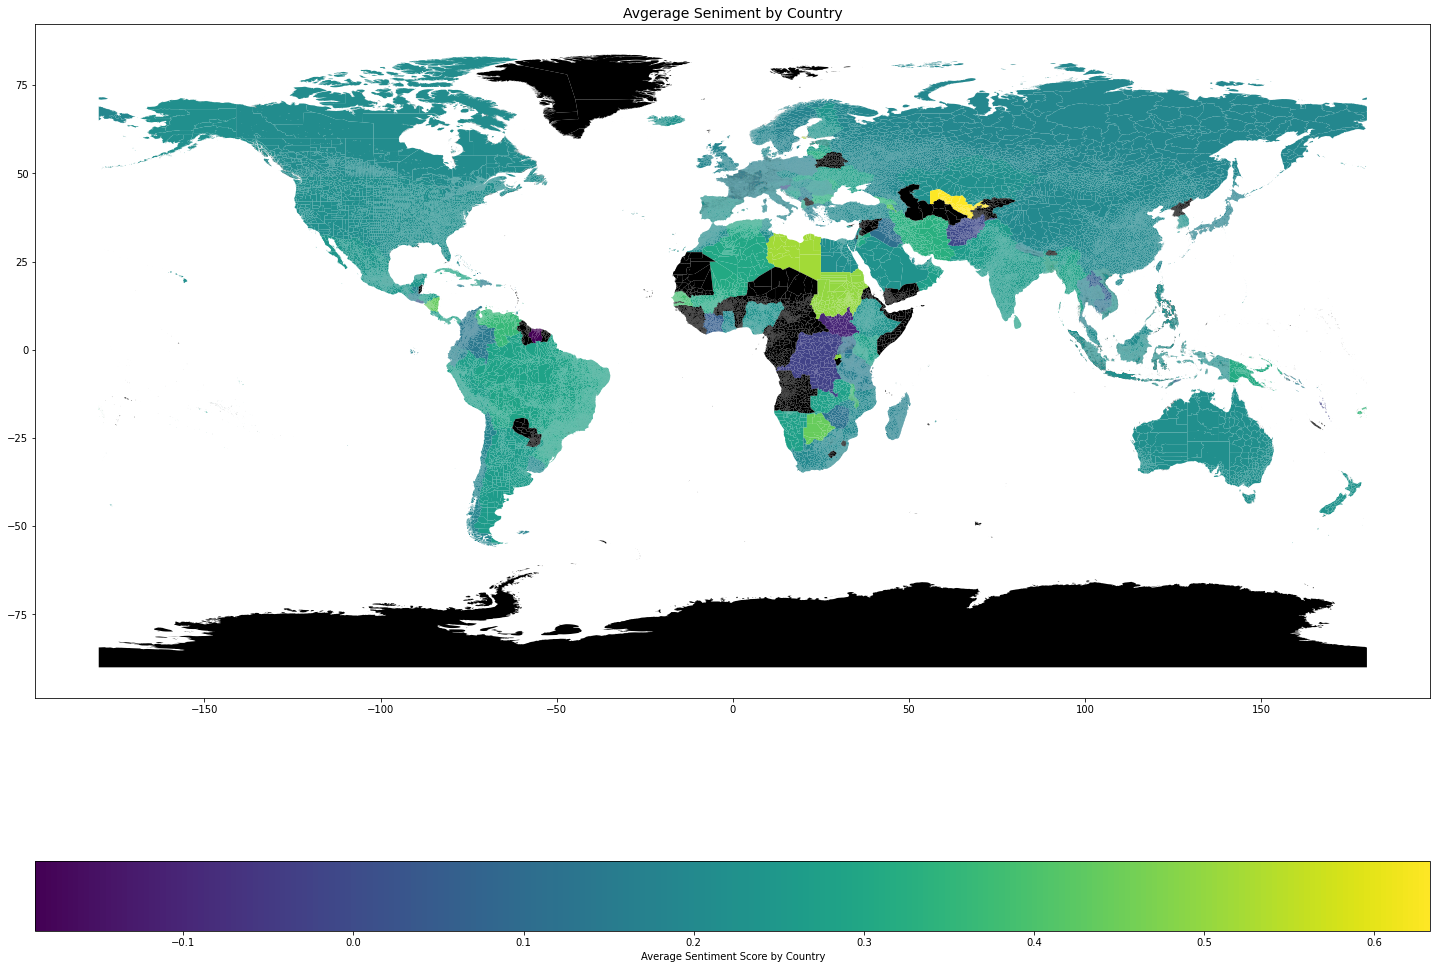

In [65]:
samp.plot(
     legend=True, 
     legend_kwds={'label': "Average Sentiment Score by Country", 'orientation': "horizontal"},
     column="avg_sent",
     figsize=(25,20),
     missing_kwds={
         "color": "black"})

plt.title('Avgerage Seniment by Country', fontsize=14)
plt.savefig('/content/drive/MyDrive/DisLandReviews/no_stops_world_sentiment_map.png', transparent=True)

In [ ]:
# samp.to_file('/content/drive/MyDrive/DisLandReviews/world_sentiment.gpkg', driver='GPKG')

## Reviews based on star ratings

In [178]:
one_star = sentiment_df[sentiment_df['rating'] == 1]
two_star = sentiment_df[sentiment_df['rating'] == 2]
thr_star = sentiment_df[sentiment_df['rating'] == 3]
fou_star = sentiment_df[sentiment_df['rating'] == 4]
fiv_star = sentiment_df[sentiment_df['rating'] == 5]

In [ ]:
ish = dict(fiv_star.country.value_counts())
cntry_percent = []
n = 1
for cntry in fiv_star.country:
  cntry_percent.append(round((ish[cntry]/fiv_star.shape[0]) * 100, 5 ))
  # print(n, ' of ', one_star.shape[0])
  # n += 1
cntry_percent

In [ ]:
fiv_star['country_percent'] = cntry_percent
fiv_star.drop(columns=['branch','review_text','clean','no_stops','rev_len','sentiment_category','rating','sentiment_score'], inplace=True)
fiv_star.drop_duplicates(inplace=True)

In [ ]:
countries = []
percents = []
for countr in fiv_star.country:
  countries.append(countr)
  for percent in fiv_star.country_percent:
    percents.append(percent)

cntry_per_dict = dict(zip(countries, percents))
cntry_per_dict

In [256]:
cntries = []
n = 1
for cntry in world_gdf.NAME_0:
  cntries.append(cntry)
  # print(n, ' of ', world_gdf.shape[0])
  # n += 1

country_list = set(cntries)
print(len(cntries))
print(len(country_list))

339127
256


In [257]:
locs = []
cents = []

for location in country_list:
  locs.append(location)
  for x in range(len(country_list)):
    x = np.nan
    cents.append(x)

world_dict = dict(zip(locs, cents))

In [258]:
not_in_ = {}
for place, v in world_dict.items():
  if place in cntry_per_dict.keys():
    pass
  else:
    not_in_[place] = np.nan

cntry_per_dict.update(not_in_)
cntry_per_dict

In [260]:
def this(db, old, new):
  cntry_per_dict[new] = round(ish[old] / db.shape[0] * 100, 5)
  print(cntry_per_dict[new])

In [261]:
fiv_star = sentiment_df[sentiment_df['rating'] == 5]

In [ ]:
this(fiv_star, 'U.S. Virgin Islands', 'Virgin Islands, U.S.')
this(fiv_star, 'Caribbean Netherlands', 'Bonaire, Sint Eustatius and Saba')
# this(fiv_star, 'Macedonia', 'North Macedonia')
this(fiv_star, 'Åland Islands', 'Åland')
this(fiv_star, 'Czechia', 'Czech Republic')
this(fiv_star, 'Macau', 'Macao')
this(fiv_star, 'Myanmar (Burma)', 'Myanmar')
this(fiv_star, 'The Bahamas', 'Bahamas')
this(fiv_star, 'Falkland Islands (Islas Malvinas)', 'Falkland Islands')

In [ ]:
percents = []
n = 1
for cntry in world_gdf.NAME_0:
  percents.append(cntry_per_dict[cntry])
  print(n, ' of ', world_gdf.shape[0])
  n += 1

In [266]:
world_gdf['country_percent'] = percents
samp = geopandas.GeoDataFrame()
samp['Code'] = world_gdf.GID_0
samp['Country'] = world_gdf.NAME_0
samp['Zone'] = world_gdf.zone
samp['geometry'] = world_gdf.geometry
samp['country_percent'] = world_gdf.country_percent

In [ ]:
samp.plot(
     legend=True, 
     legend_kwds={'label': "Percentage of reviews based on country", 'orientation': "horizontal"},
     column="country_percent",
     figsize=(25,20),
     missing_kwds={
         "color": "black"})

plt.title('Percent of reviews by country for 5-Star reviews', fontsize=14)
plt.savefig('/content/drive/MyDrive/DisLandReviews/fiv_star_reviews_map.png', transparent=True)

## Country percent based on sentiment

In [90]:
pos = sentiment_df[sentiment_df['sentiment_category'] == 'positive']
neg = sentiment_df[sentiment_df['sentiment_category'] == 'negative']

In [91]:
ish = dict(pos.country.value_counts())
cntry_percent = []
n = 1
for cntry in pos.country:
  cntry_percent.append(round((ish[cntry]/pos.shape[0]) * 100, 5 ))
  # print(n, ' of ', one_star.shape[0])
  # n += 1
# cntry_percent

In [ ]:
pos['country_percent'] = cntry_percent
pos.drop(columns=['branch','review_text','clean','no_stops','rev_len','sentiment_category','rating','sentiment_score'], inplace=True)
pos.drop_duplicates(inplace=True)

In [93]:
countries = []
percents = []
for countr in pos.country:
  countries.append(countr)
  for percent in pos.country_percent:
    percents.append(percent)

cntry_per_dict = dict(zip(countries, percents))
# cntry_per_dict

In [ ]:
cntries = []
n = 1
for cntry in world_gdf.NAME_0:
  cntries.append(cntry)
  # print(n, ' of ', world_gdf.shape[0])
  # n += 1

country_list = set(cntries)
print(len(cntries))
print(len(country_list))

In [95]:
locs = []
cents = []

for location in country_list:
  locs.append(location)
  for x in range(len(country_list)):
    x = np.nan
    cents.append(x)

world_dict = dict(zip(locs, cents))

In [96]:
not_in_ = {}
for place, v in world_dict.items():
  if place in cntry_per_dict.keys():
    pass
  else:
    not_in_[place] = np.nan

cntry_per_dict.update(not_in_)
# cntry_per_dict

In [97]:
def this(db, old, new):
  cntry_per_dict[new] = round(ish[old] / db.shape[0] * 100, 5)
  print(cntry_per_dict[new])

In [98]:
pos = sentiment_df[sentiment_df['sentiment_category'] == 'positive']

In [ ]:
this(pos, 'U.S. Virgin Islands', 'Virgin Islands, U.S.')
this(pos, 'Caribbean Netherlands', 'Bonaire, Sint Eustatius and Saba')
# this(pos, 'Macedonia', 'North Macedonia')
this(pos, 'Åland Islands', 'Åland')
this(pos, 'Czechia', 'Czech Republic')
this(pos, 'Macau', 'Macao')
this(pos, 'Myanmar (Burma)', 'Myanmar')
this(pos, 'The Bahamas', 'Bahamas')
this(pos, 'Falkland Islands (Islas Malvinas)', 'Falkland Islands')

In [ ]:
percents = []
n = 1
for cntry in world_gdf.NAME_0:
  percents.append(cntry_per_dict[cntry])
  print(n, ' of ', world_gdf.shape[0])
  n += 1

In [102]:
world_gdf['country_percent'] = percents
samp = geopandas.GeoDataFrame()
samp['Code'] = world_gdf.GID_0
samp['Country'] = world_gdf.NAME_0
samp['Zone'] = world_gdf.zone
samp['geometry'] = world_gdf.geometry
samp['country_percent'] = world_gdf.country_percent

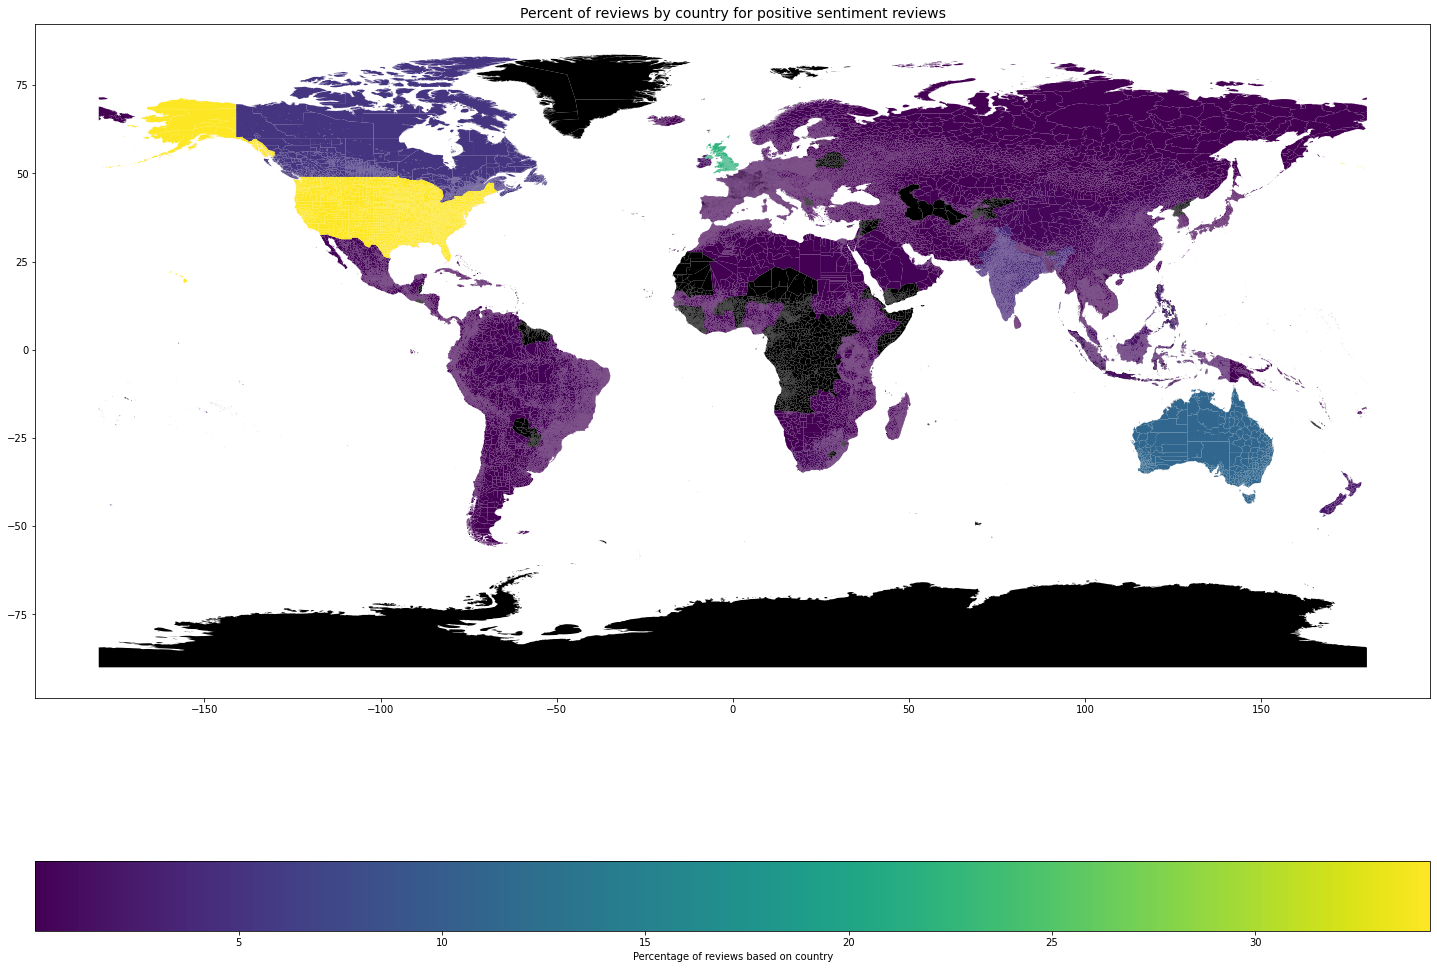

In [103]:
samp.plot(
     legend=True, 
     legend_kwds={'label': "Percentage of reviews based on country", 'orientation': "horizontal"},
     column="country_percent",
     figsize=(25,20),
     missing_kwds={
         "color": "black"})

plt.title('Percent of reviews by country for positive sentiment reviews', fontsize=14)
plt.savefig('/content/drive/MyDrive/DisLandReviews/no_stops_positive_reviews_map.png', transparent=True)

## Average star rating by country

In [ ]:
avg_rat = []
n = 1
for cntry in sentiment_df.country:
  samp = sentiment_df[sentiment_df.country == cntry]
  sent = round((samp.rating.sum() / samp.shape[0]),4)
  avg_rat.append(sent)  
  print(n, ' of ', sentiment_df.shape[0])
  n+=1

sentiment_df['avg_rat'] = avg_rat
sentiment_df.drop(columns=['branch','review_text','clean','no_stops','rev_len','sentiment_category','rating','sentiment_score'], inplace=True)
sentiment_df.drop_duplicates(inplace=True)

In [32]:
countries = []
percents = []
for countr in sentiment_df.country:
  countries.append(countr)
  for percent in sentiment_df.avg_rat:
    percents.append(percent)

cntry_per_dict = dict(zip(countries, percents))

In [ ]:
cntries = []
n = 1
for cntry in world_gdf.NAME_0:
  cntries.append(cntry)
  print(n, ' of ', world_gdf.shape[0])
  n += 1


country_list = set(cntries)
print(len(cntries))
print(len(country_list))

In [34]:
locs = []
cents = []

for location in country_list:
  locs.append(location)
  for x in range(len(country_list)):
    x = np.nan
    cents.append(x)

world_dict = dict(zip(locs, cents))

In [35]:
not_in_ = {}
for place, v in world_dict.items():
  if place in cntry_per_dict.keys():
    pass
  else:
    not_in_[place] = np.nan

cntry_per_dict.update(not_in_)

In [37]:
def this(db, old, new):
  samp = db[db.country == old]
  cntry_per_dict[new] = round((samp.rating.sum() / samp.shape[0]),4)
  print(cntry_per_dict[new])

In [38]:
sentiment_df = pd.DataFrame([list(disrev.Branch), list(disrev.Reviewer_Location), list(disrev['Rating']), sentiment_scores_tb, sentiment_category_tb, list(disrev.Review_Text), list(disrev.clean), list(disrev.no_stops), list(disrev.rev_len)]).T
sentiment_df.columns = ['branch', 'country', 'rating',  'sentiment_score', 'sentiment_category', 'review_text', 'clean', 'no_stops', 'rev_len']
sentiment_df['sentiment_score'] = sentiment_df.sentiment_score.astype('float')
sentiment_df['rating'] = sentiment_df.rating.astype('int64')

In [ ]:
this(sentiment_df, 'U.S. Virgin Islands', 'Virgin Islands, U.S.')
this(sentiment_df, 'Caribbean Netherlands', 'Bonaire, Sint Eustatius and Saba')
this(sentiment_df, 'Macedonia', 'North Macedonia')
this(sentiment_df, 'Åland Islands', 'Åland')
this(sentiment_df, 'Czechia', 'Czech Republic')
this(sentiment_df, 'Macau', 'Macao')
this(sentiment_df, 'Myanmar (Burma)', 'Myanmar')
this(sentiment_df, 'The Bahamas', 'Bahamas')
this(sentiment_df, 'Falkland Islands (Islas Malvinas)', 'Falkland Islands')

In [ ]:
percents = []
n = 1
for cntry in world_gdf.NAME_0:
  percents.append(cntry_per_dict[cntry])
  print(n, ' of ', world_gdf.shape[0])
  n += 1

In [41]:
world_gdf['avg_rat'] = percents
samp = geopandas.GeoDataFrame()
samp['Code'] = world_gdf.GID_0
samp['Country'] = world_gdf.NAME_0
samp['Zone'] = world_gdf.zone
samp['geometry'] = world_gdf.geometry
samp['avg_rat'] = world_gdf.avg_rat

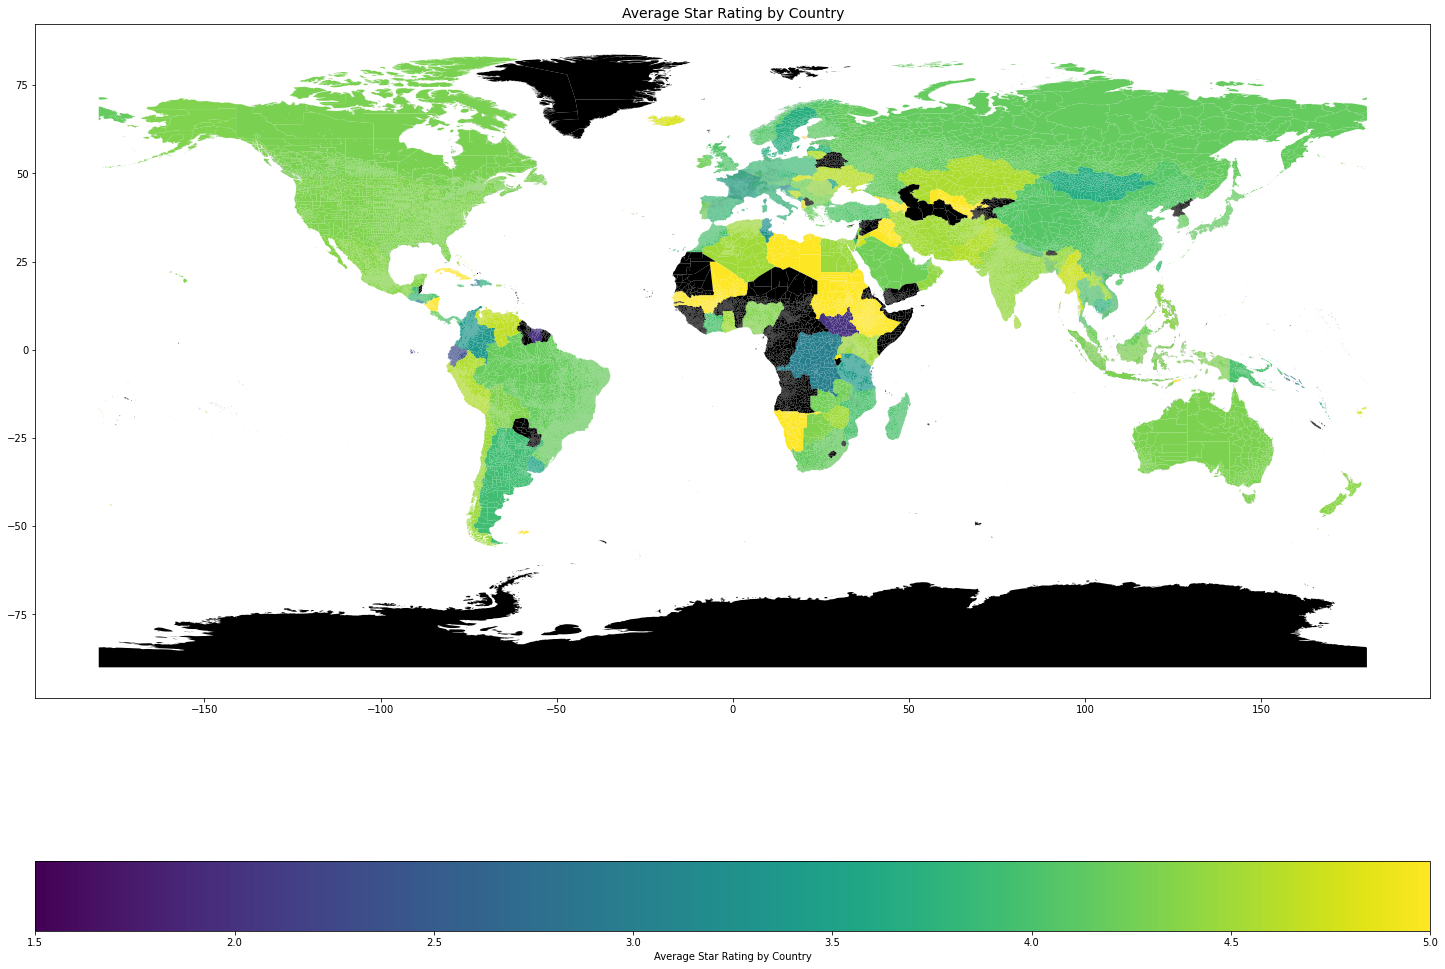

In [42]:
samp.plot(
     legend=True, 
     legend_kwds={'label': "Average Star Rating by Country", 'orientation': "horizontal"},
     column="avg_rat",
     figsize=(25,20),
     missing_kwds={
         "color": "black"})

plt.title('Average Star Rating by Country', fontsize=14)
plt.savefig('/content/drive/MyDrive/DisLandReviews/world_rating_map.png', transparent=True)

In [ ]:
# samp.to_file('/content/drive/MyDrive/DisLandReviews/world_sentiment.gpkg', driver='GPKG')